In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

#### Gaussian Distribution
$$
\mathcal{N} (\mu, \sigma^2) = \frac{1}{\sqrt{2\pi}\sigma^2} {e}^{\frac{-(x - \mu)^2}{2\sigma^2}}
$$
where $\mu$ is the mean (center of the distribution) and $\sigma^2$ is the variance (spread of the distribution).

#### Laplace Distribution
$$
\mathcal{L} (\mu, b) = \frac{1}{2b} e^{\frac{-|x - \mu|}{b}}
$$
where $\mu$ is the location parameter and $b$ is the scale parameter.

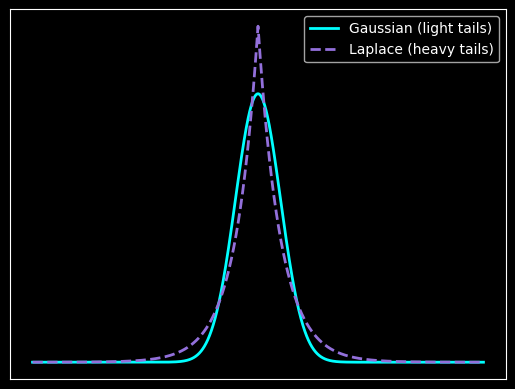

In [2]:
mu = 0
sigma = 1
b = 1

x = np.linspace(-10, 10, 8000)
gaussian_pdf = (1 / (np.sqrt(2 * np.pi)* sigma)) * np.exp(-(x - mu)**2/(2*sigma**2))
laplace_pdf = (1 / (2 * b)) * np.exp(-np.abs(x - mu) / b)

# Visualize tails
plt.style.use('dark_background')
plt.plot(x, gaussian_pdf, label='Gaussian (light tails)', color='cyan', linewidth=2)
plt.plot(x, laplace_pdf, label='Laplace (heavy tails)', color='mediumpurple', linestyle='--', linewidth=2)
plt.xticks([])
plt.yticks([])
plt.legend()
plt.show()

In [3]:
# generate synthetic data X and targets y with added noise
def curating_data(rng=None, num_samples=100, num_features=10, noise_kind="gaussian"):
    if rng is None:
        rng = np.random.default_rng(42)

    X = rng.normal(0, 1, size=(num_samples, num_features))

    w_true = rng.normal(0, 1, size=num_features)

    if noise_kind == "gaussian":
        noise = rng.normal(0, 1, size=num_samples)
    elif noise_kind == "laplace":
        noise = rng.laplace(0, 1, size=num_samples)
    else:
        raise ValueError(f"Unknown distribution of noise: {noise_kind}")

    y = X @ w_true + noise

    return X, y, w_true    

In [4]:
def absolute_loss(y, y_pred):
    return np.abs(y - y_pred)

def bounded_loss(y, y_pred, M=5.0):
    return np.minimum((y - y_pred)**2, M)

- $n$ : number of samples
- $d$ : number of features
- $\hat L = \frac{1}{n} \sum_{i=1}^n \ell(y_i, \hat y_i)$ : empirical mean loss  
- $L = \mathbb{E}[\ell(y, \hat y)]$ : true expected loss  (we don't know anything about this)
- $M$ : upper bound on the loss (for Hoeffding)  i.e., $0\leq \ell \leq M$
- $\epsilon$ : allowed deviation from true mean  
- $\delta$ : confidence level i.e., $P(|\hat L - L| \leq \epsilon) \geq \delta$ 
- So, $1-\delta$ is the probability that the empirical mean has deviated by $\epsilon$ from true mean

**Hoeffding bound (for bounded loss):**  
$$
P(|\hat L - L| > \epsilon) \le 2 \exp\Big(-\frac{2 n \epsilon^2}{M^2}\Big), \quad n \ge \frac{M^2}{2 \epsilon^2} \log \frac{2}{(1-\delta)}
$$

**Bernstein bound (for finite variance / sub-Gaussian):**  
$$
P(|\hat L - L| > \epsilon) \le 2 \exp(-c n \epsilon^2), \quad n \ge \frac{1}{c \epsilon^2} \log \frac{2}{(1-\delta)}, \quad c \approx \frac{1}{2 \sigma^2}
$$


In [10]:
def experiment(n, d, loss_fns, noise_kind="gaussian", M=5.0, lr=0.01, max_epochs=500, epsilon=0.1, delta=0.5):
    
    X, y, _ = curating_data(num_samples=n, num_features=d, noise_kind=noise_kind)

    # split the data
    n_train = int(0.8 * n)
    X_train, X_test = X[:n_train], X[n_train:]
    y_train, y_test = y[:n_train], y[n_train:]

    # initialize weights
    w = np.random.uniform(-1, 1, size=d)
    
    # training_mse_losses = []
    
    for epoch in range(max_epochs):
        
        y_pred = X_train @ w
        
        # mse_loss = np.mean(0.5*(y_pred - y_train)**2)
        # training_mse_losses.append(mse_loss)

        # gradient descent
        grad = X_train.T @ (y_pred - y_train) / n_train
        # update weights
        w -= lr*grad

    # else w via normal equation (closed-form)
    # w = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y
    
    y_train_pred = X_train @ w
    y_test_pred = X_test @ w
    
    results = {}
    for fn in loss_fns:
        train_loss = np.mean(fn(y_train, y_train_pred))
        test_loss  = np.mean(fn(y_test, y_test_pred))
        results[fn.__name__] = (train_loss, test_loss)

    # for the variance to be calculated on training set
    abs_loss = absolute_loss(y_train, y_train_pred)

    # Hoeffding bound for bounded loss
    n_hoeffding = math.ceil((M**2/(2*epsilon**2))* math.log(2/(1-delta)))
    # number of samples for atleast bounded loss is not deviated by it's emirical loss {L_bounded:.2f} by {epsilon} with {delta} confidence
    print(f"Required n (Hoeffding): {n_hoeffding}")
    
    sigma2 = np.var(abs_loss)
    c = 1 / (2 * sigma2)   # approximate for sub-Gaussian
    n_bernstein = math.ceil((1 / (c * epsilon**2)) * math.log(2/(1-delta)))
    print(f"Required n (Bernstein): {n_bernstein}")
    
    return results    

In [11]:
n = 500
d = 10

In [12]:
loss_fns = [ absolute_loss, bounded_loss]

In [13]:
for noise in ["gaussian", "laplace"]:
    print("\n","="*20, f"Noise: {noise}", "="*20, "\n")
    results = experiment(n, d, loss_fns, noise_kind=noise, max_epochs=500)
    
    print("\n\nLoss results (Train | Test):\n")
    for k, v in results.items():
        print(f"{k}: {v[0]:.2f}, {v[1]:.2f}")


 ==================== Noise: gaussian ==================== 

Required n (Hoeffding): 1733
Required n (Bernstein): 98


Loss results (Train | Test):

absolute_loss: 0.80, 0.79
bounded_loss: 0.94, 0.91

 ==================== Noise: laplace ==================== 

Required n (Hoeffding): 1733
Required n (Bernstein): 278


Loss results (Train | Test):

absolute_loss: 1.03, 0.99
bounded_loss: 1.33, 1.29


---
### Required number of samples for bounds
- Hoeffding: 1733 for both noises
  - Depends only on range M, so it's the same for Gaussian and Laplace
  - Guarantees the empirical mean loss is within $\epsilon$ of the true mean with confidence $\delta$
- Bernstein: 98 (Gaussian) vs 278 (Laplace)
  - Depends on variance of the loss
  - Laplace has higher variance. Hence, it requires more samples to get the same confidence
    
#### Since Laplace noise has heavier tails, losses are lager compared to gaussian one's
---